# Prototype of projection the EIOPA curve n-years year ahead and recalibrating the Smith Wilson algorithm to the new curve

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [2]:
from ImportData import importSWEiopa
from Curves import Curves

## Import Param file

In [3]:
paramfile = pd.read_csv("Parameters.csv")
paramfile.index = paramfile["Parameter"]
del paramfile["Parameter"]

## Read base EIOPA curve from file

In [4]:
selected_param_file = paramfile.loc["EIOPA_param_file"][0]
selected_curves_file = paramfile.loc["EIOPA_curves_file"][0]
country = paramfile.loc["country"][0]

[maturities_country, curve_country, extra_param, Qb]= importSWEiopa(selected_param_file, selected_curves_file, country)

## Initiate Curve object

In [5]:
# ultimate forward rate
ufr = extra_param["UFR"]/100
# Numeric precision of the optimisation
Precision = float(paramfile.loc["Precision"][0])

# Targeted distance between the extrapolated curve and the ultimate forward rate at the convergence point
Tau = float(paramfile.loc["Tau"][0])# 1 basis point

Country = paramfile.loc["country"]

InitialDate = paramfile.loc["Modelling_Date"]

In [6]:
Curves = Curves(ufr, Precision, Tau, InitialDate, Country)

In [7]:
Curves.M_Obs = pd.DataFrame(data=range(1,curve_country.size+1),index=None, columns=["Maturity"])
Curves.r_Obs = pd.DataFrame(data=curve_country.values, index=None, columns=["Yield"])

### Calculate 1 year forward rates

The forward rates will be used to calculate forward spot curves

In [8]:
fwdata = ((Curves.r_Obs["Yield"]+1) ** Curves.M_Obs["Maturity"])/((Curves.r_Obs["Yield"].shift(periods=1)+1) ** Curves.M_Obs["Maturity"].shift(periods=1))

In [9]:
Curves.FwdRates = pd.DataFrame(data=fwdata.values, index=None, columns=["Forward"])

### Forward spot rates

$$
y_i(t-i) = \prod_i^t\big(1+fw_{EIOPA}(t)\big)^{\frac{1}{t-i}}


$$

In [10]:
# Number of projection years
N = int(paramfile.loc["n_proj_years"][0])

In [11]:
#EIOPA_curvefwd = EIOPA_curve

for year in range(1,N):
    spot = ((1+Curves.FwdRates["Forward"][year:]).cumprod(axis=None)**(1/(Curves.M_Obs["Maturity"]-year))-1)[year:]-1
    Curves.r_Obs=Curves.r_Obs.join(pd.Series(data=spot.values, index=None, name="Yield year"+str(year)))

In [12]:
display(Curves.r_Obs)

,Yield,Yield year1,Yield year2,Yield year3,Yield year4,Yield year5,Yield year6,Yield year7,Yield year8,Yield year9,...,Yield year40,Yield year41,Yield year42,Yield year43,Yield year44,Yield year45,Yield year46,Yield year47,Yield year48,Yield year49
0,0.03472,0.031582,0.027909,0.026170,0.026146,0.026663,0.027041,0.027560,0.028290,0.028950,...,0.033653,0.033492,0.033733,0.033531,0.034204,0.033982,0.033731,0.033931,0.034131,0.034332
1,0.03315,0.029745,0.027039,0.026158,0.026404,0.026852,0.027301,0.027925,0.028620,0.028010,...,0.033573,0.033612,0.033632,0.033867,0.034093,0.033856,0.033831,0.034031,0.034232,0.034176
2,0.03140,0.028552,0.026741,0.026326,0.026617,0.027088,0.027631,0.028267,0.028104,0.029452,...,0.033626,0.033585,0.033823,0.033906,0.033972,0.033881,0.033931,0.034131,0.034161,0.034184
3,0.03009,0.027951,0.026722,0.026505,0.026853,0.027389,0.027960,0.027968,0.029161,0.029882,...,0.033602,0.033740,0.033862,0.033862,0.033962,0.033944,0.034031,0.034104,0.034171,0.034233
4,0.02930,0.027693,0.026786,0.026716,0.027140,0.027701,0.027782,0.028841,0.029563,0.029543,...,0.033723,0.033788,0.033836,0.033876,0.033996,0.034021,0.034029,0.034123,0.034213,0.034299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.03274,0.032739,0.032757,0.032801,0.032856,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146,0.03275,0.032749,0.032768,0.032811,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147,0.03276,0.032760,0.032778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
148,0.03277,0.032770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Calibrate every yield curve

### Parameters that stay the same

#### Calculated implied observations for the first year of projection

In [13]:
ProjYear = 1
NameOfYear = "Yield year"+str(ProjYear)


In [14]:
r_Obs = np.transpose(np.array(Curves.r_Obs[NameOfYear]))[:-ProjYear]

#### Calculated implied maturities for the first year of projection

In [15]:
M_Obs = np.transpose(np.array(range(1,r_Obs.size+1)))

#### Calibrate

In [16]:
alphaoptimized = [Curves.BisectionAlpha(0.05, 0.5, M_Obs, r_Obs, Curves.ufr, Curves.Tau, Curves.Precision, 1000)]

In [17]:
if NameOfYear in Curves.alpha.columns:
    Curves.alpha[NameOfYear] = alphaoptimized
else:
    Curves.alpha = Curves.alpha.join(pd.Series(data=None, index=None, name=NameOfYear,dtype='float64'))
    Curves.alpha[NameOfYear] = alphaoptimized

In [18]:
bCalibrated = Curves.SWCalibrate(r_Obs, M_Obs, Curves.ufr, Curves.alpha[NameOfYear][0])
bCalibrated = np.append(bCalibrated,np.repeat(np.nan,ProjYear-1))

In [19]:
if NameOfYear in Curves.b.columns:
    Curves.b[NameOfYear] = bCalibrated
else:
    Curves.b = Curves.b.join(pd.Series(data= None,index=None, name=NameOfYear,dtype='float64'))
    Curves.b[NameOfYear] = bCalibrated

In [20]:
r_Obs_Est = Curves.SWExtrapolate(M_Obs, M_Obs, Curves.b[NameOfYear], Curves.ufr, Curves.alpha[NameOfYear][0])

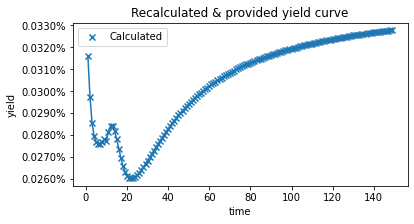

In [21]:
fig, ax1 = plt.subplots(1,1)
ax1.scatter(M_Obs, r_Obs, label="Calculated",marker="x")
ax1.plot(M_Obs, r_Obs_Est)
ax1.set_ylabel("yield")
ax1.set_title('Recalculated & provided yield curve')
ax1.set_xlabel("time")
ax1.legend()
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
fig.set_figwidth(6)
fig.set_figheight(3)
plt.show()

# Repeat for second projected year

In [22]:
ProjYear = 2
NameOfYear = "Yield year"+str(ProjYear)

In [23]:
r_Obs = np.transpose(np.array(Curves.r_Obs[NameOfYear]))[:-ProjYear]

In [24]:
M_Obs = np.transpose(np.array(range(1,r_Obs.size+1)))

In [25]:
alphaoptimized = [Curves.BisectionAlpha(0.05, 0.5, M_Obs, r_Obs, Curves.ufr, Curves.Tau, Curves.Precision, 1000)]

In [26]:
if NameOfYear in Curves.alpha.columns:
    Curves.alpha[NameOfYear] = alphaoptimized
else:
    Curves.alpha = Curves.alpha.join(pd.Series(data=None, index=None, name=NameOfYear,dtype='float64'))
    Curves.alpha[NameOfYear] = alphaoptimized

In [27]:
bCalibrated = Curves.SWCalibrate(r_Obs, M_Obs, Curves.ufr, Curves.alpha[NameOfYear][0])

In [28]:
bCalibrated = np.append(bCalibrated,np.repeat(np.nan,ProjYear-1))

In [30]:
if NameOfYear in Curves.b.columns:
    Curves.b[NameOfYear] = bCalibrated
else:
    Curves.b = Curves.b.join(pd.Series(data= None,index=None, name=NameOfYear,dtype='float64'))
    Curves.b[NameOfYear] = bCalibrated

In [31]:
r_Obs_Est = Curves.SWExtrapolate(M_Obs, M_Obs, Curves.b[NameOfYear][:-(ProjYear-1)], Curves.ufr, Curves.alpha[NameOfYear][0])

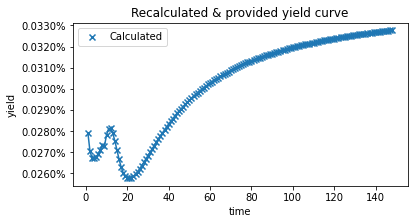

In [32]:
fig, ax1 = plt.subplots(1,1)
ax1.scatter(M_Obs, r_Obs, label="Calculated",marker="x")
ax1.plot(M_Obs, r_Obs_Est)
ax1.set_ylabel("yield")
ax1.set_title('Recalculated & provided yield curve')
ax1.set_xlabel("time")
ax1.legend()
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
fig.set_figwidth(6)
fig.set_figheight(3)
plt.show()

# Repeat for all

In [35]:
for iYear in range(2,50):
    ProjYear = iYear
    NameOfYear = "Yield year"+str(ProjYear)
    r_Obs = np.transpose(np.array(Curves.r_Obs[NameOfYear]))[:-ProjYear]
    M_Obs = np.transpose(np.array(range(1,r_Obs.size+1)))
    alphaoptimized = [Curves.BisectionAlpha(0.05, 0.5, M_Obs, r_Obs, Curves.ufr, Curves.Tau, Curves.Precision, 1000)]
    if NameOfYear in Curves.alpha.columns:
        Curves.alpha[NameOfYear] = alphaoptimized
    else:
        Curves.alpha = Curves.alpha.join(pd.Series(data=None, index=None, name=NameOfYear,dtype='float64'))
        Curves.alpha[NameOfYear] = alphaoptimized
    bCalibrated = Curves.SWCalibrate(r_Obs, M_Obs, Curves.ufr, Curves.alpha[NameOfYear][0])
    bCalibrated = np.append(bCalibrated,np.repeat(np.nan,ProjYear-1))
    if NameOfYear in Curves.b.columns:
        Curves.b[NameOfYear] = bCalibrated
    else:
        Curves.b = Curves.b.join(pd.Series(data= None,index=None, name=NameOfYear,dtype='float64'))
        Curves.b[NameOfYear] = bCalibrated
    r_Obs_Est = Curves.SWExtrapolate(M_Obs, M_Obs, Curves.b[NameOfYear][:-(ProjYear-1)], Curves.ufr, Curves.alpha[NameOfYear][0])

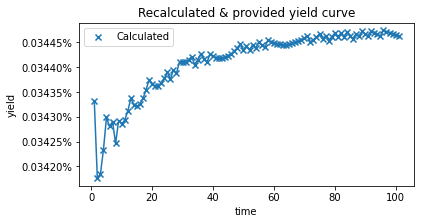

In [38]:
fig, ax1 = plt.subplots(1,1)
ax1.scatter(M_Obs, r_Obs, label="Calculated",marker="x")
ax1.plot(M_Obs, r_Obs_Est)
ax1.set_ylabel("yield")
ax1.set_title('Recalculated & provided yield curve')
ax1.set_xlabel("time")
ax1.legend()
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
fig.set_figwidth(6)
fig.set_figheight(3)
plt.show()